<a href="https://colab.research.google.com/github/vit050587/Python-for-Data-Science/blob/master/Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **[Real Estate Price Prediction](https://www.kaggle.com/c/real-estate-price-prediction-moscow/)**

# Kaggle-Competition-Price-Prediction
## Description
* Ваша задача этом соревновании - предсказать цены на квартиры в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).
* Invite link for this competition: https://www.kaggle.com/t/b4c9382d4f934176af9fe860b1976528
## Evaluation
* The evaluation metric is [Coefficient of determination](https://studopedia.ru/9_153900_viborochnaya-kovariatsiya-i-viborochnaya-dispersiya.html):

$$
R^2=1−\frac{σ^2}{σ^2_y}
$$

![image.png](https://raw.githubusercontent.com/vit050587/Kaggle-Competition-Price-Prediction/master/Files/home_price.png)

# File descriptions

**Подключение библиотек и скриптов**

In [3]:
# импортирование библиотек:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

* train.csv - the training set
* test.csv - the test set
* sampleSubmission.csv - a sample submission file in the correct format

**Прописали пути к дата сету и другим файлам**

In [7]:
TRAIN_DATASET_PATH = 'https://raw.githubusercontent.com/vit050587/Kaggle-Competition-Price-Prediction/master/Files/train.csv'
TEST_DATASET_PATH = 'https://raw.githubusercontent.com/vit050587/Kaggle-Competition-Price-Prediction/master/Files/test.csv'
SAMPLE = 'https://raw.githubusercontent.com/vit050587/Kaggle-Competition-Price-Prediction/master/Files/sample_submission.csv'

In [5]:
# установка единого размера шрифта:
matplotlib.rcParams.update({'font.size': 14})

In [6]:
# функция для оценивания качества работы модели прогнозирования:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# Data fields

**Расшифровка Датасета**

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=",")
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [10]:
train_df.shape

(10000, 20)

In [11]:
train_df.index

RangeIndex(start=0, stop=10000, step=1)

In [12]:
train_df.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

**Вывели серию с количеством комнат по каждой квартре**

In [13]:
train_df['Rooms']

0       3.0
1       1.0
2       3.0
3       1.0
4       2.0
       ... 
9995    2.0
9996    2.0
9997    1.0
9998    1.0
9999    1.0
Name: Rooms, Length: 10000, dtype: float64

In [19]:
# просмотр тестового датасета:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [20]:
# просмотр количества строк в датасетах:
print('Строк в тренировочном датасете:', train_df.shape[0])
print('Строк в тестовом датасете', test_df.shape[0])

Строк в тренировочном датасете: 10000
Строк в тестовом датасете 5000


**Приведение типов данных**

In [14]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

# EDA:
## Делаем EDA для:
* Исправления выбросов
* Заполнения NaN
* Идей для генерации новых фич
## Целевая переменная:

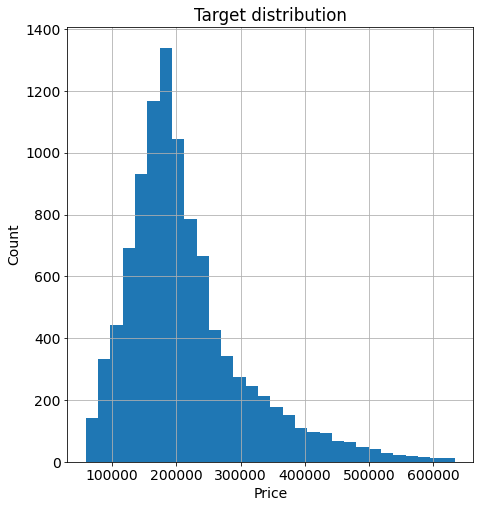

In [21]:
plt.figure(figsize = (16, 8))
plt.subplot(121)
train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

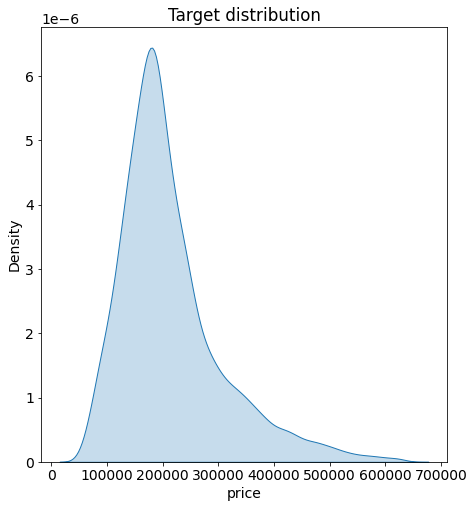

In [22]:
plt.figure(figsize = (16, 8))
plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('price')

plt.title('Target distribution')
plt.show()

## Матрица кореляции:

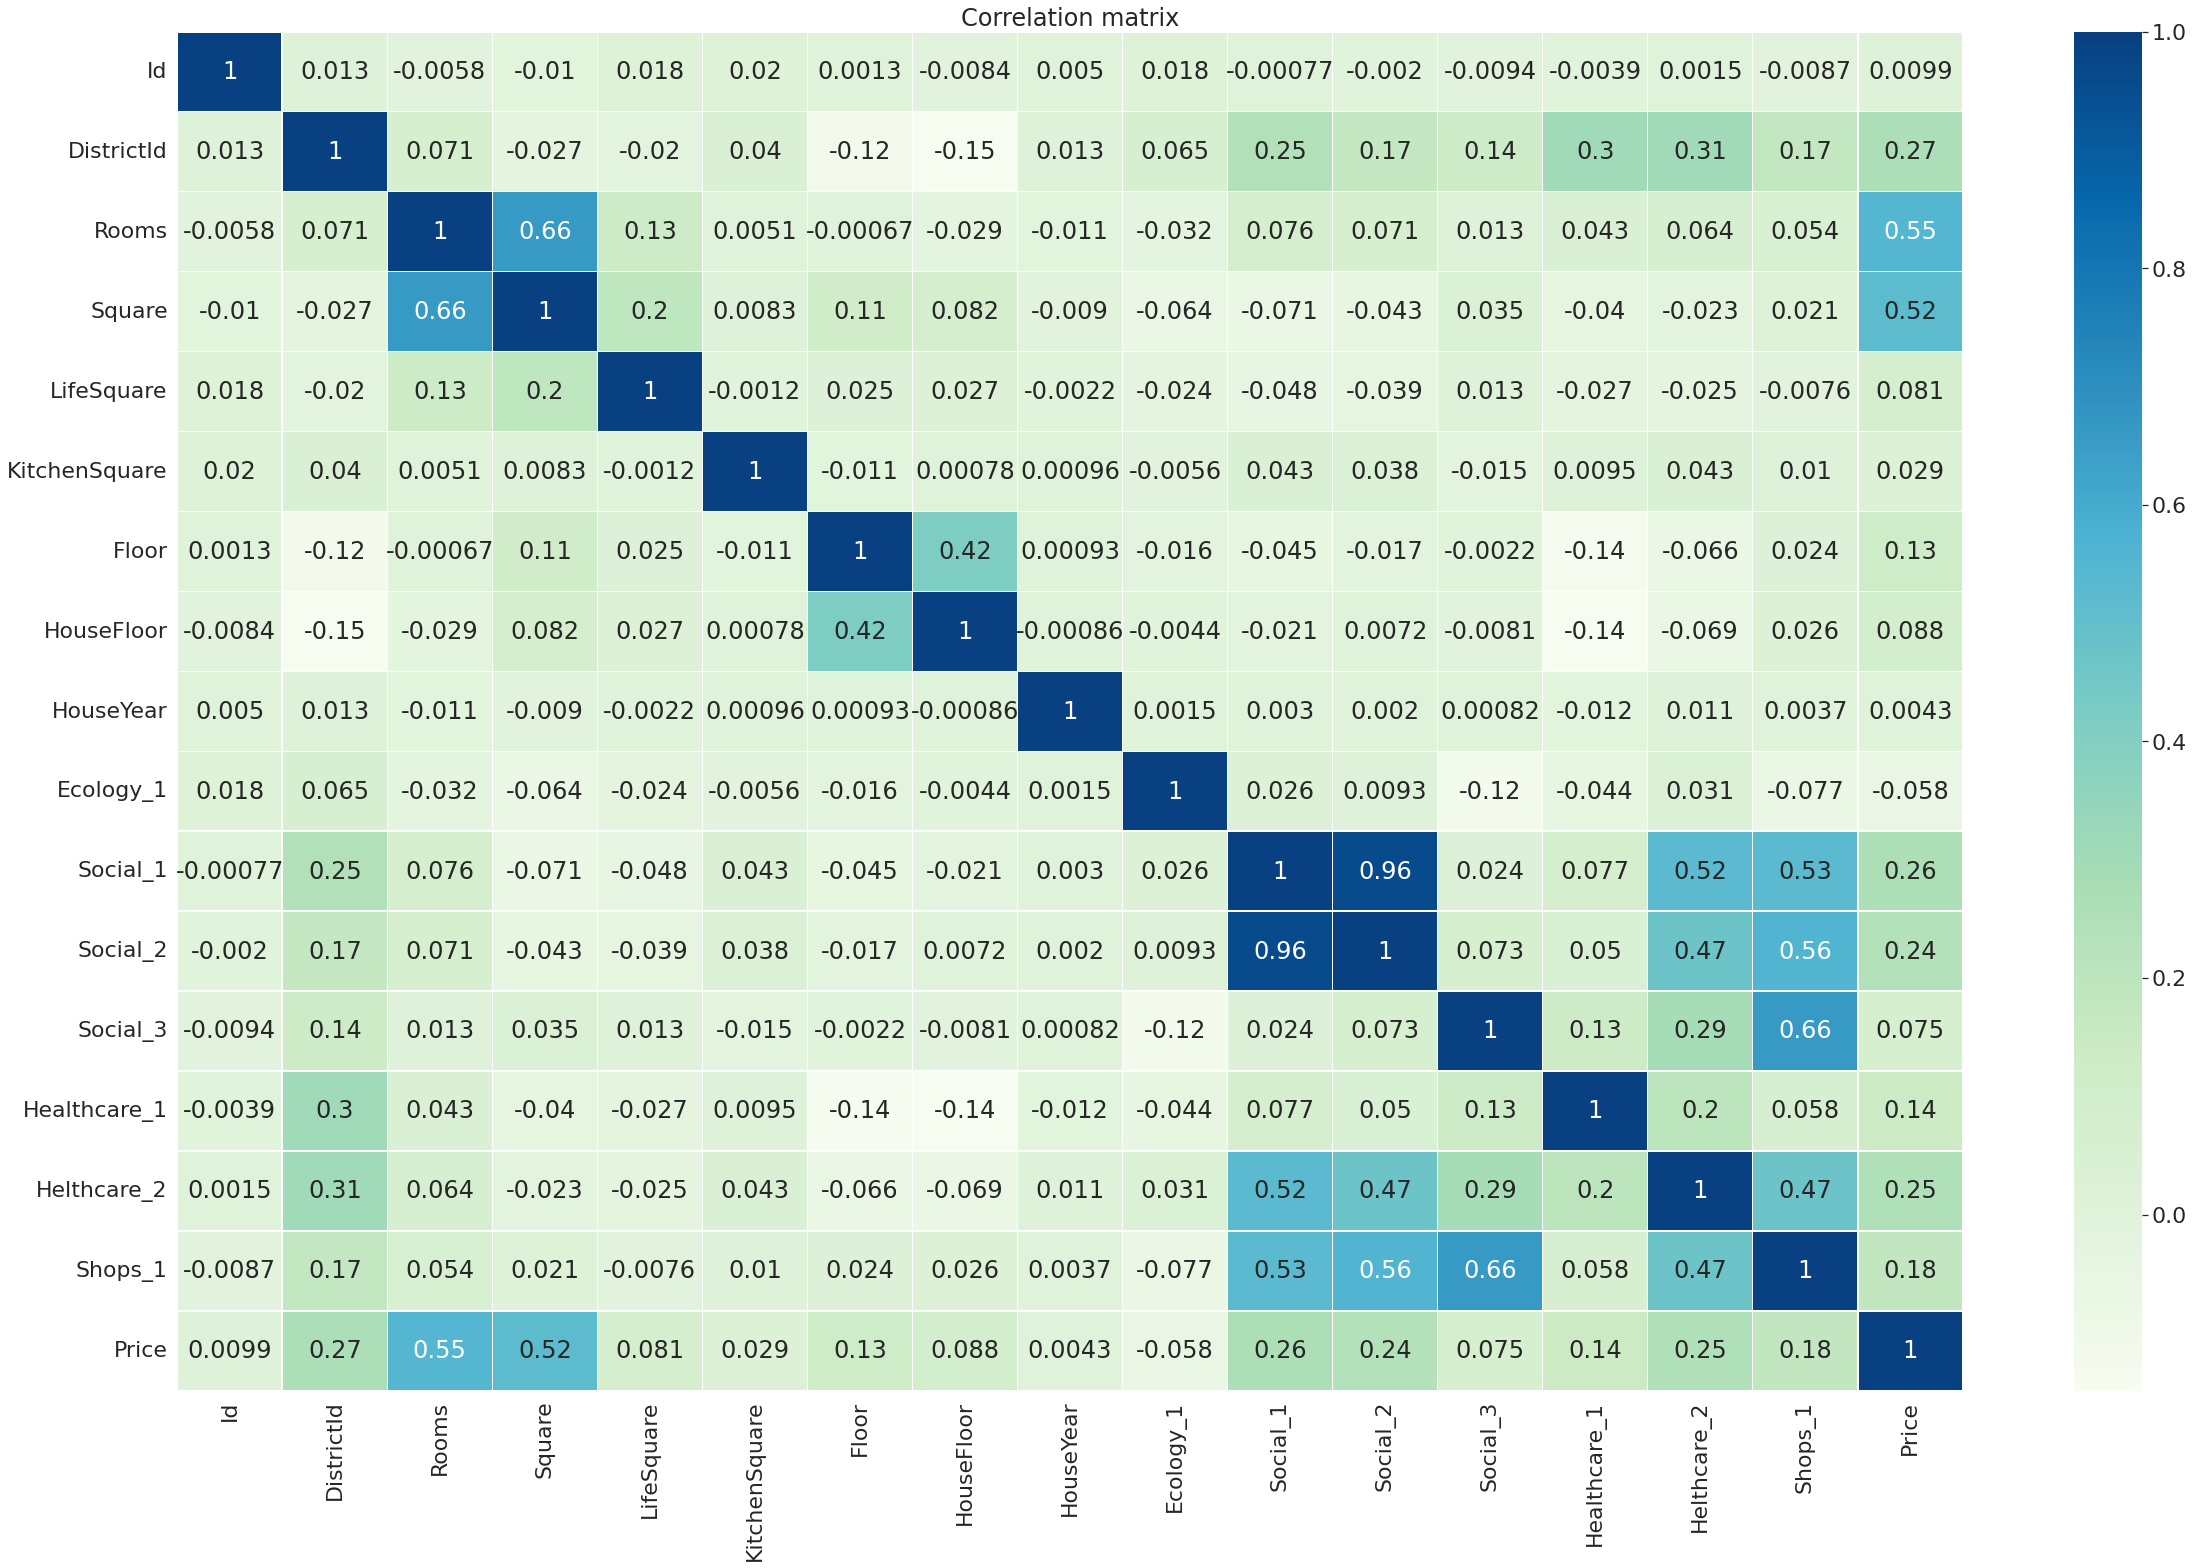

In [23]:
plt.figure(figsize = (40,25))

sns.set(font_scale=2)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

## Количественные переменные:¶

**Первичное понимание того, что из себя представляют данные**

In [25]:
# первичный анализ количественных  признаков, через  описательные статистики
# проверяем пропуски
# сравниваем средние с медианой
# проверка максимальных  и минимальных  значений
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

**Посмотрим количество квартир в соответствии с их количеством комнат**

In [17]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

# Обработка пропусков

In [18]:
train_df.isna()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
9998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Жилая пложадь

In [ ]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [ ]:
df['LifeSquare_NaN'] = 0
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_NaN
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855,0


In [ ]:
df['LifeSquare'].isna()

0        True
1       False
2       False
3        True
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: LifeSquare, Length: 10000, dtype: bool

In [ ]:
df.loc[df['LifeSquare'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_NaN
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,0
18,4581,1,1.0,47.582480,NaN,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810,0
20,8768,63,1.0,50.974891,NaN,1.0,7,16.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,260328.413376,0
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,4944,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184,0
9978,4851,1,1.0,39.314342,NaN,1.0,13,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,137782.941940,0
9981,6753,62,2.0,73.092686,NaN,1.0,4,16.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,159077.198056,0
9983,647,1,2.0,63.324025,NaN,1.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114,0


In [ ]:
df.loc[df['LifeSquare'].isna(), 'LifeSquare_NaN']

0       0
3       0
18      0
20      0
24      0
       ..
9975    0
9978    0
9981    0
9983    0
9991    0
Name: LifeSquare_NaN, Length: 2113, dtype: int64

In [ ]:
df.loc[df['LifeSquare'].isna(), 'LifeSquare_NaN'] = 1

In [ ]:
df[df['LifeSquare_NaN'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_NaN
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,1
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,1
18,4581,1,1.0,47.582480,NaN,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810,1
20,8768,63,1.0,50.974891,NaN,1.0,7,16.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,260328.413376,1
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,4944,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184,1
9978,4851,1,1.0,39.314342,NaN,1.0,13,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,137782.941940,1
9981,6753,62,2.0,73.092686,NaN,1.0,4,16.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,159077.198056,1
9983,647,1,2.0,63.324025,NaN,1.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114,1


In [ ]:
df['LifeSquare_NaN'].value_counts()

0    7887
1    2113
Name: LifeSquare_NaN, dtype: int64

In [ ]:
median = df['LifeSquare'].median()
df['LifeSquare'].fillna(median).isna().sum()

0

In [ ]:
df['LifeSquare'].isna().sum()

2113

In [ ]:
df['LifeSquare'] = df['LifeSquare'].fillna(median)

In [ ]:
df['LifeSquare'].isna().sum()

0

In [ ]:
df[df['LifeSquare_NaN'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_NaN
0,11809,27,3.0,115.027311,32.78126,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,1
3,2352,1,1.0,40.409907,32.78126,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,1
18,4581,1,1.0,47.582480,32.78126,1.0,16,16.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,128803.593810,1
20,8768,63,1.0,50.974891,32.78126,1.0,7,16.0,2018,0.238617,B,B,26,3889,6,705.0,3,6,B,260328.413376,1
24,4717,27,1.0,44.203947,32.78126,0.0,2,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,135466.559958,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,4944,6,2.0,52.573133,32.78126,1.0,18,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,154366.031184,1
9978,4851,1,1.0,39.314342,32.78126,1.0,13,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,137782.941940,1
9981,6753,62,2.0,73.092686,32.78126,1.0,4,16.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A,159077.198056,1
9983,647,1,2.0,63.324025,32.78126,1.0,4,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,183809.327114,1


## Показатели месности по охране здоровья 1 категория

In [ ]:
df.isna().sum()

Id                   0
DistrictId           0
Rooms                0
Square               0
LifeSquare           0
KitchenSquare        0
Floor                0
HouseFloor           0
HouseYear            0
Ecology_1            0
Ecology_2            0
Ecology_3            0
Social_1             0
Social_2             0
Social_3             0
Healthcare_1      4798
Helthcare_2          0
Shops_1              0
Shops_2              0
Price                0
LifeSquare_NaN       0
dtype: int64

In [ ]:
df['Healthcare_1_NaN'] = 0
df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_NaN,Healthcare_1_NaN
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,1,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407,0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850,0,0
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,1,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796,0,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807,0,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580,0,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855,0,0


In [ ]:
df['Healthcare_1'].isna()

0        True
1       False
2       False
3        True
4        True
        ...  
9995     True
9996     True
9997     True
9998    False
9999     True
Name: Healthcare_1, Length: 10000, dtype: bool

In [ ]:
df.loc[df['Healthcare_1'].isna()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_NaN,Healthcare_1_NaN
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,1,0
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,1,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0,0
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732,0,0
11,16755,88,2.0,53.975144,34.153584,8.0,2,12.0,1978,0.127376,B,B,43,8429,3,NaN,3,9,B,253124.005332,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,9289,1,3.0,84.486078,88.931509,0.0,4,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,264213.558631,0,0
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796,0,0
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807,0,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580,0,0


In [ ]:
df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_NaN']

0       0
3       0
4       0
8       0
11      0
       ..
9993    0
9995    0
9996    0
9997    0
9999    0
Name: Healthcare_1_NaN, Length: 4798, dtype: int64

In [ ]:
df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_NaN'] = 1

In [ ]:
df[df['Healthcare_1_NaN'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_NaN,Healthcare_1_NaN
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089,1,1
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630,1,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962,0,1
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732,0,1
11,16755,88,2.0,53.975144,34.153584,8.0,2,12.0,1978,0.127376,B,B,43,8429,3,NaN,3,9,B,253124.005332,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,9289,1,3.0,84.486078,88.931509,0.0,4,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,264213.558631,0,1
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796,0,1
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807,0,1
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580,0,1


In [ ]:
df['Healthcare_1_NaN'].value_counts()

0    5202
1    4798
Name: Healthcare_1_NaN, dtype: int64

In [ ]:
median = df['Healthcare_1'].median()
df['Healthcare_1'].fillna(median, inplace=True)

In [ ]:
df[df['Healthcare_1_NaN'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_NaN,Healthcare_1_NaN
0,11809,27,3.0,115.027311,32.781260,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,900.0,0,0,B,305018.871089,1,1
3,2352,1,1.0,40.409907,32.781260,1.0,10,22.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,168106.007630,1,1
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,900.0,0,6,B,343995.102962,0,1
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,900.0,0,1,B,160400.401732,0,1
11,16755,88,2.0,53.975144,34.153584,8.0,2,12.0,1978,0.127376,B,B,43,8429,3,900.0,3,9,B,253124.005332,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,9289,1,3.0,84.486078,88.931509,0.0,4,22.0,2016,0.007122,B,B,1,264,0,900.0,0,1,B,264213.558631,0,1
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,900.0,1,9,B,119367.455796,0,1
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,900.0,0,0,A,199715.148807,0,1
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,900.0,1,5,B,165953.912580,0,1


In [ ]:
df['Healthcare_1'].isna().sum()

0

In [ ]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
LifeSquare_NaN      0
Healthcare_1_NaN    0
dtype: int64

## Вариант упрощени и обработки пропусков подстановкой медианы сразу для всех признаков

In [ ]:
medians = df[['LifeSquare', 'Healthcare_1']].median()
medians

LifeSquare       32.78126
Healthcare_1    900.00000
dtype: float64

In [ ]:
df[['LifeSquare', 'Healthcare_1']] = \
        df[['LifeSquare', 'Healthcare_1']].fillna(medians, inplace = True)

# Обработка выбросов

In [ ]:
df.describe()

,Id,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,LifeSquare_NaN,Healthcare_1_NaN
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.857399,0.211300,0.479800
std,4859.01902,43.587592,0.839512,21.058732,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.293865,0.408251,0.499617
min,0.00000,0.000000,0.000000,1.136859,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942,0.000000,0.000000
50%,8394.50000,36.000000,2.000000,52.513310,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879,0.000000,0.000000
75%,12592.50000,75.000000,2.000000,65.900625,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171,0.000000,1.000000
max,16798.00000,209.000000,19.000000,641.065193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570,1.000000,1.000000
